In [75]:
from prometheus_api_client import PrometheusConnect
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [136]:
plt.style.use('fivethirtyeight')
sns.set_style('darkgrid')
sns.set_context("notebook", rc={
    "font.size": 8,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "axes.labelspacing": 10,
})

In [3]:
pc = PrometheusConnect(url="http://localhost:9090")

In [176]:
start_time = pd.Timestamp('2023-05-08T12:20:00IST')
end_time = pd.Timestamp('2023-05-08T13:30:00IST')

In [5]:
def query_metric(query, start_time, end_time):
    return pc.custom_query_range(query, start_time, end_time, '1m')

In [157]:
# Returns a 2D array of size (num_nodes, num_values)
# num_values depends on the start and end time given when fetching the metric
def extract_values(raw_metric):
    metric = []

    # scaler = StandardScaler()
    for data in raw_metric:
        d = np.array(data['values']).T[1]
        # scaled_d = scaler.fit_transform(d.reshape((-1, 1))).flatten()
        metric.append(d)
    
    return np.array(metric, dtype=np.float64)

In [77]:
def createDataFrame(raw_metric):
    unix_ts = np.array(raw_metric[0]['values']).T[0]
    timestamp = [pd.Timestamp(datetime.fromtimestamp(int(ts))) for ts in unix_ts]

    d = {'Timestamp': timestamp}
    for data in raw_metric:
        fullNodeName = data['metric'].get('node') or data['metric'].get('kubernetes_io_hostname')
        nodeName = f'gke-cluster1-node-{fullNodeName.split("-")[-1]}'
        values = np.array(data['values']).astype(np.float64).T[1]
        d[nodeName] = values
    
    return pd.DataFrame(d).set_index('Timestamp')

In [79]:
def createNodeMetricDataFrame(metrics, metric_names):
    unix_ts = np.array(metrics[0][0]['values']).T[0]
    timestamp = [pd.Timestamp(datetime.fromtimestamp(int(ts))) for ts in unix_ts]

    num_nodes = len(metrics[0])
    dicts = [{'Timestamp': timestamp} for _ in range(num_nodes)]

    for metric, metric_name in zip(metrics, metric_names):
        arr = extract_values(metric)
        for i in range(num_nodes):
            dicts[i][metric_name] = arr[i, :]
    
    return [pd.DataFrame(d).set_index('Timestamp') for d in dicts]

In [96]:
def plot_df(df, ylabel, title):
    ax = sns.lineplot(data=df, dashes=False)
    ax.set(ylabel=ylabel, title=title)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

In [81]:
def plot_metric(query, ylabel, title):
    raw_metric = query_metric(query, start_time, end_time)
    df = createDataFrame(raw_metric)
    plot_df(df, ylabel, title)

### Node Metrics

In [171]:
queries = [
    'avg(rate(node_cpu_seconds_total{mode="user"}[10m])) by (node) * 1000',

    'sum(rate(istio_requests_total{namespace="default"}[10m])\
        + on(pod) group_left(node)\
        kube_pod_info{namespace="default"}) by (node) * 5',

    'sum(rate(istio_request_duration_milliseconds_sum{namespace="default"}[10m])\
        + on(pod) group_left(node)\
        kube_pod_info{namespace="default"}) by (node) / 5',
    
    '(sum(rate(node_network_transmit_bytes_total[10m])) by (node)) / 1000'
]

In [172]:
nodeNames = [
    'gke-cluster-1-node-0r0m',
    'gke-cluster-1-node-818b',
    'gke-cluster-1-node-dmtp',
    'gke-cluster-1-node-hpfb',
]

In [182]:
start_time = pd.Timestamp('2023-05-09T22:50:00IST')
end_time = pd.Timestamp('2023-05-09T23:30:00IST')

In [183]:
metrics = [query_metric(query, start_time, end_time) for query in queries]
metric_names = ['cpu usage', 'http requests received', 'http response duration', 'network transmit bytes']

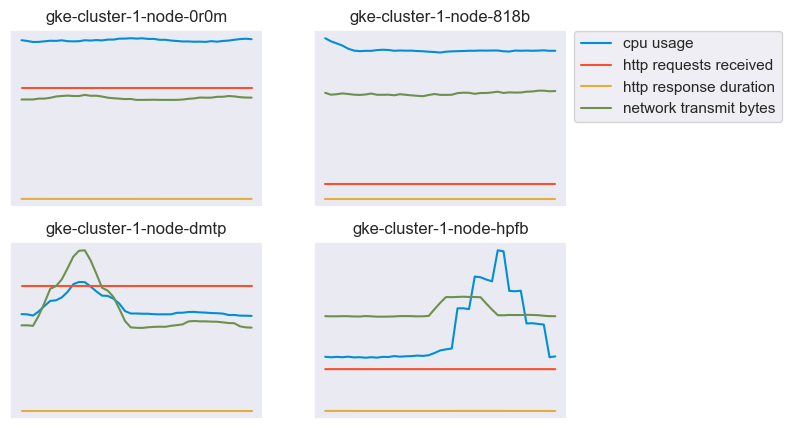

In [184]:
dfs = createNodeMetricDataFrame(metrics, metric_names)
for i, df in enumerate(dfs):
    plt.subplot(220 + i + 1)
    ax = sns.lineplot(data=df, dashes=False)
    ax.set(title=nodeNames[i], xticks=[], yticks=[], xlabel="")
    ax.get_legend().remove()
plt.legend(loc='upper left', bbox_to_anchor=(1, 2.238))
plt.show()

### Separate Metrics

In [153]:
queries = [
    'avg(rate(node_cpu_seconds_total{mode="user"}[10m])) by (node) * 1000',

    'sum(1 - (node_memory_MemAvailable_bytes / node_memory_MemTotal_bytes)) by (node) * 100',

    'sum(rate(istio_requests_total{namespace="default"}[10m])\
        + on(pod) group_left(node)\
        kube_pod_info{namespace="default"}) by (node)',

    '(sum(rate(node_network_transmit_bytes_total[10m])) by (node))',
    
    '(sum(rate(node_network_receive_bytes_total[10m])) by (node))',
]

In [154]:
description = [
    ('CPU usage percentage (%)', 'Node CPU usage'),
    ('Memory usage percentage (%)', 'Node Memory usage'),
    ('Rate of change of http requests', 'HTTP Requests Received'),
    ('Rate of change of data transmitted (Bytes)', 'Network Transmit Bytes'),
    ('Rate of change of data received (Bytes)', 'Network Receive Bytes'),
]

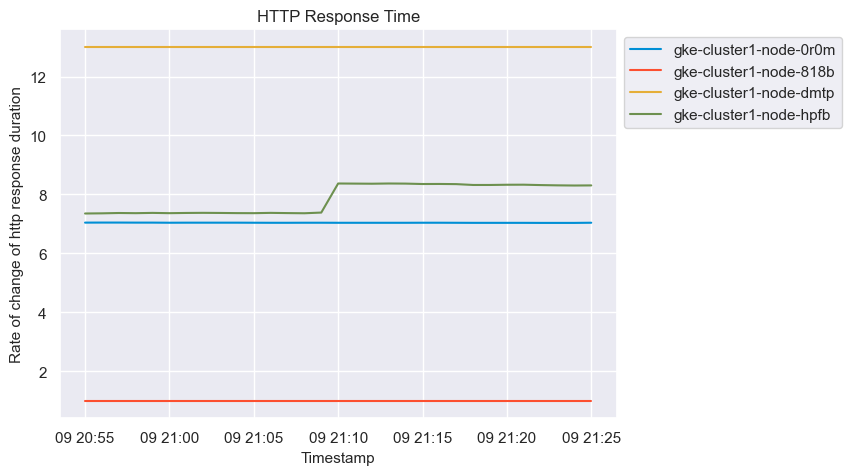

In [155]:
q = 'sum(rate(istio_request_duration_milliseconds_sum{namespace="default"}[10m])\
        + on(pod) group_left(node)\
        kube_pod_info{namespace="default"}) by (node)'
plot_metric(q, 'Rate of change of http response duration', 'HTTP Response Time')

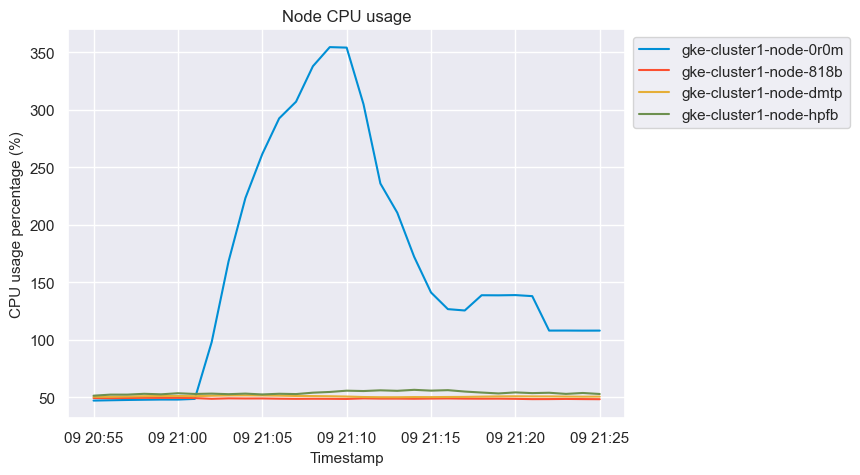

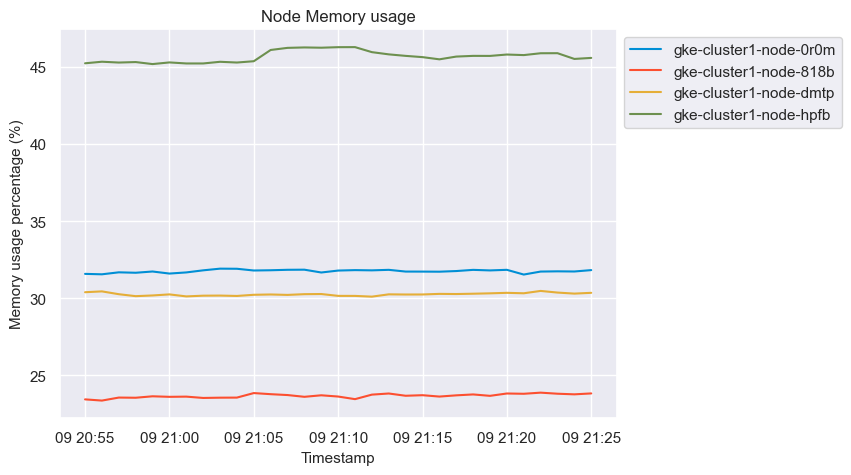

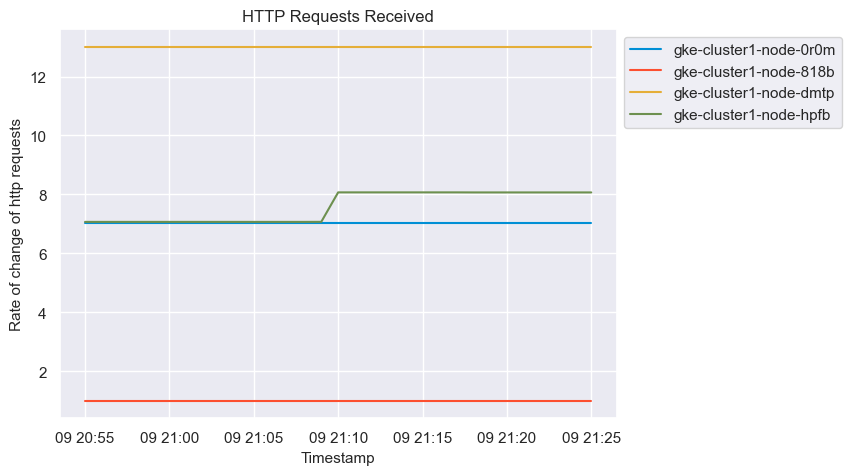

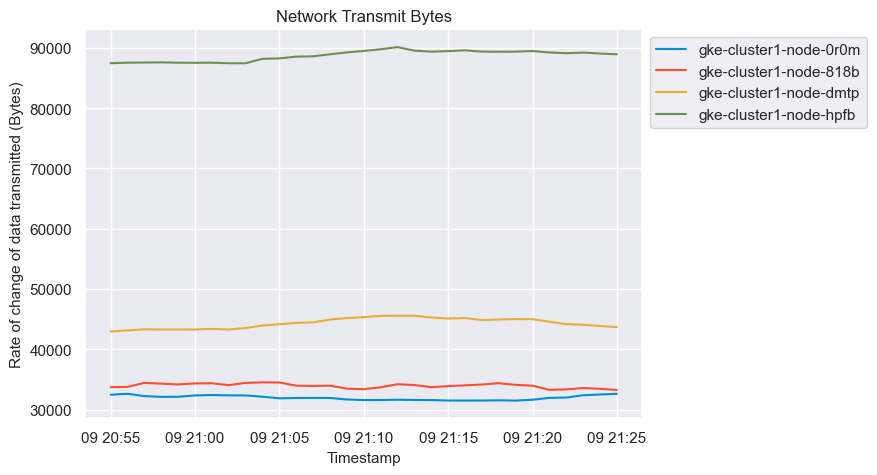

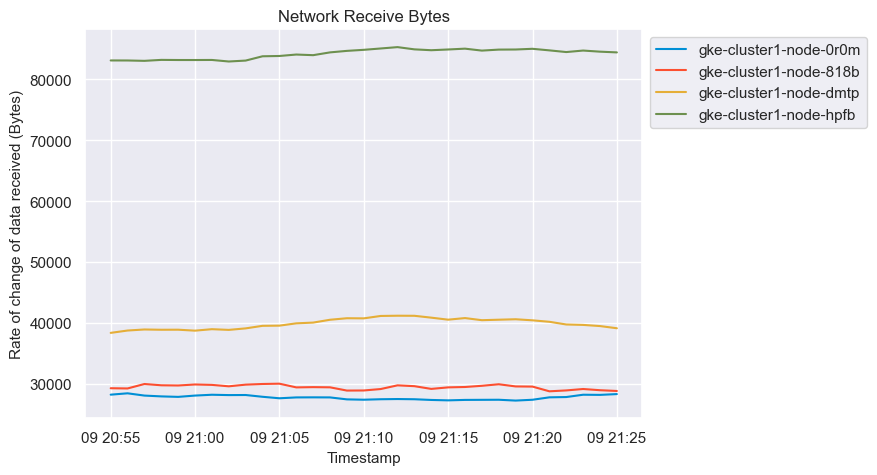

In [156]:
for query, (ylabel, title) in zip(queries, description):
    plot_metric(query, ylabel, title)